In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.special import erf
import h5py


plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [55]:
subvolumes = [
    "0_0_0",
    "0_0_1",
    "0_1_0",
    "0_1_1",
    "1_0_0",
    "1_0_1",
    "1_1_0",
    "1_1_1"
]

sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_forestmgmt_fidSAM'

# Initialize lists to hold data from all subvolumes
mdot = []
z = []
max_pos = []
mstar = []
mhalo = []
mbh = []

with h5py.File(f'{sam_dir}/volume.hdf5', 'r') as file:
    for subvol in subvolumes:
        # Read maccdot, redshift, mstar
        mdot_subvol1 = file[f'{subvol}/Galprop/GalpropMaccdot_bright'][:] # Msun/yr
        mdot_subvol2 = file[f'{subvol}/Galprop/GalpropMaccdot_radio'][:] # Msun/yr
        mdot_subvol = mdot_subvol1 

        z_subvol = file[f'{subvol}/Galprop/GalpropRedshift'][:]
        mstar_subvol = file[f'{subvol}/Galprop/GalpropMstar'][:] * 1e9 # Msun
        mhalo_subvol = file[f'{subvol}/Galprop/GalpropMhalo'][:] * 1e9 # Msun
        mbh_subvol = file[f'{subvol}/Galprop/GalpropMBH'][:] * 1e9 # Msun
        
        # Get maximum size of subvolume
        pos_subvol = file[f'{subvol}/Galprop/GalpropPos'][:] # cMpc
        max_pos_subvol = np.max(pos_subvol, axis=0)
        
        # Append to the lists
        mdot.append(mdot_subvol)
        z.append(z_subvol)
        max_pos.append(max_pos_subvol)
        mstar.append(mstar_subvol)
        mhalo.append(mhalo_subvol)
        mbh.append(mbh_subvol)

# Combine data from all subvolumes into single arrays
mdot = np.concatenate(mdot) 
z = np.concatenate(z)
mstar = np.concatenate(mstar)
mhalo = np.concatenate(mhalo)
mbh = np.concatenate(mbh)

print('Mstar range before cut:', min(mstar), '-', max(mstar))
print("Total number of galaxies before cut:", mdot.size)

print(len(mstar), len(mhalo))

# Apply mass cut
m_min = 10**11.5
mask = mhalo > m_min 

#mdot = mdot[mask]
#z = z[mask]
print("Total number of galaxies after cut:", mdot.size)

# Check volume of each subvolume
print('Lengths of subvolumes:')
for i in max_pos :
    print(i)

Mstar range before cut: 0.0 - 1.49746e+12
Total number of galaxies before cut: 1706375
1706375 1706375
Total number of galaxies after cut: 1706375
Lengths of subvolumes:
[151.772 149.407 149.281]
[149.274 149.416 149.216]
[151.133 150.08  149.279]
[149.182 149.004 149.952]
[149.264 149.323 149.083]
[150.372 149.639 149.502]
[150.475 149.723 149.224]
[149.275 149.364 149.278]


Min z: 0.0
Max z: 0.227446


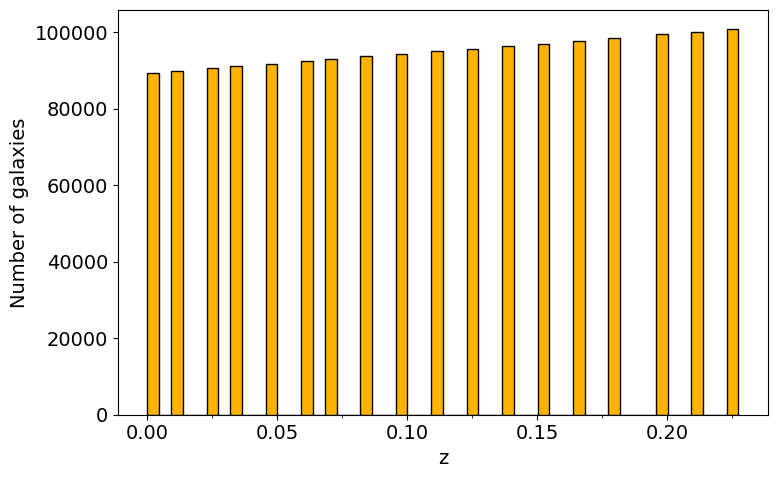

In [56]:
print('Min z:', min(z))
print('Max z:', max(z))

# z histogram
plt.figure(figsize=(8,5))
plt.hist(z, 50,
         edgecolor="black",
         facecolor="#ffb300")
plt.xlabel(r"z")
plt.ylabel("Number of galaxies")
#plt.title(f'z = {min(z)} - {max(z)}')
plt.tight_layout()

# set minor ticks every 0.025
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(0.025))

plt.show()

In [57]:
# Get L_bol values

# Filter out zero mdot values to avoid issues with log scale 
nonzero_mdot = mdot[mdot > 0]
z = z[mdot > 0]

print('Total mdot values:', len(mdot))
print('Number of these that are not zero:', len(nonzero_mdot) )

print('Min mdot:', min(nonzero_mdot))
print('Max mdot:', max(nonzero_mdot))

#L_bol = 0.1 * (nonzero_mdot * 1.9891e33 / 3.154e7) * (3e10)**2 # erg/s

# compute in log space to avoid overflow
# convert Msun/yr to g/s, use c in cm/s
log_L_bol = (
    np.log10(0.1)
    + np.log10(nonzero_mdot)
    + np.log10(1.9891e33)
    - np.log10(3.154e7)
    + 2 * np.log10(3e10)
)
L_bol = 10 ** log_L_bol

Total mdot values: 1706375
Number of these that are not zero: 64636
Min mdot: 2.24201e-06
Max mdot: 29.2563


<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_161846/3969339377.py:21: SyntaxWarning: invalid escape sequence '\d'
  """


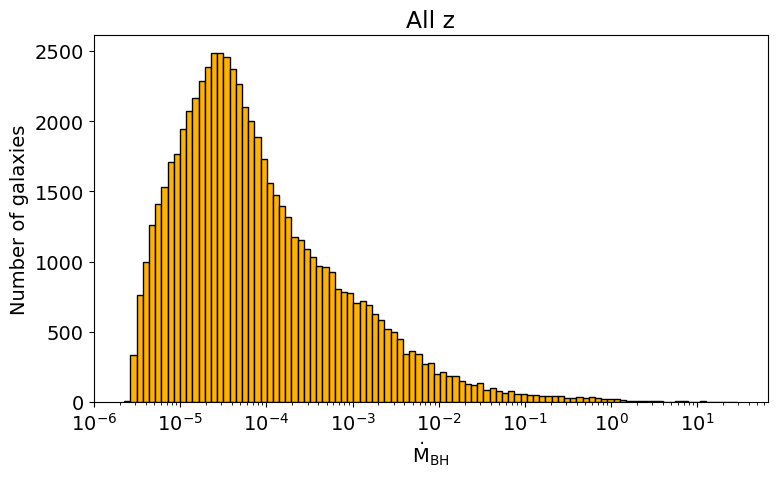

mdot peak value: 0.14628373


'\nmask = nonzero_mdot < 1e-3\nnonzero_mdot = nonzero_mdot[mask]\nplt.figure(figsize=(8,5))\nplt.hist(nonzero_mdot, bins=np.logspace(np.log10(nonzero_mdot.min()),\n                                           np.log10(nonzero_mdot.max()), 100),\n         edgecolor="black",\n         facecolor="#daa520")\nplt.xscale("log")\nplt.xlabel(r"$\rm \\dot{M}_{BH}$")\nplt.ylabel("Number of galaxies")\nplt.title(f\'z = {zmin} - {zmax}\')\nplt.tight_layout()\nplt.show()\n'

In [58]:
# Histogram with log-scaled x-axis
plt.figure(figsize=(8,5))
plt.hist(nonzero_mdot, bins=np.logspace(np.log10(nonzero_mdot.min()),
                                           np.log10(nonzero_mdot.max()), 100),
         edgecolor="black",
         facecolor="#ffb300")
plt.xscale("log")
plt.xlabel(r"$\rm \dot{M}_{BH}$")
plt.ylabel("Number of galaxies")
plt.title(f'All z')
plt.tight_layout()
plt.show()


# Find the mdot value where the histogram peaks
counts, bin_edges = np.histogram(nonzero_mdot, bins=100)
peak_bin_index = np.argmax(counts)
mdot_peak = 0.5 * (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1])
print("mdot peak value:", mdot_peak)

"""
mask = nonzero_mdot < 1e-3
nonzero_mdot = nonzero_mdot[mask]
plt.figure(figsize=(8,5))
plt.hist(nonzero_mdot, bins=np.logspace(np.log10(nonzero_mdot.min()),
                                           np.log10(nonzero_mdot.max()), 100),
         edgecolor="black",
         facecolor="#daa520")
plt.xscale("log")
plt.xlabel(r"$\rm \dot{M}_{BH}$")
plt.ylabel("Number of galaxies")
plt.title(f'z = {zmin} - {zmax}')
plt.tight_layout()
plt.show()
"""


25141.900390625 2226469888.0
1.2725500540934175e+40 1.6605687587908153e+47
3.1901813117264337e-07 1.3514183216719273


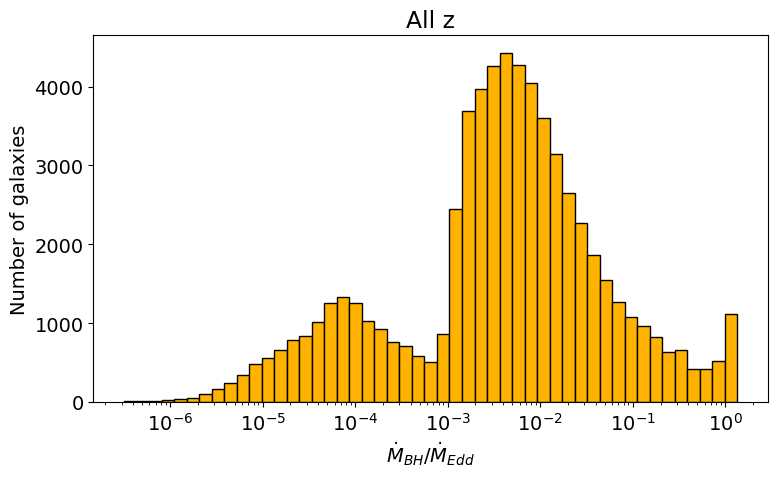

mdot peak value: 0.004305387947467827


In [59]:
# Calculate mdot in units of Eddington accretion rate

# Ensure arrays are numpy and float64
mbh_filtered = np.asarray(mbh, dtype=np.float64)[mdot > 0]
L_bol = np.asarray(L_bol, dtype=np.float64)

print(min(mbh_filtered), max(mbh_filtered))
print(min(L_bol), max(L_bol))

# Compute Eddington luminosity (erg/s)
L_edd = 1.26e38 * mbh_filtered

mdot_edd = L_bol / L_edd

print(min(mdot_edd), max(mdot_edd))

# Histogram with logarithmic x-axis
plt.figure(figsize=(8,5))
plt.hist(mdot_edd, bins=np.logspace(np.log10(mdot_edd.min()), 
                                    np.log10(mdot_edd.max()), 
                                    50),  # 50 log-spaced bins
         edgecolor="black",
         facecolor="#ffb300")
plt.xscale("log")
plt.xlabel(r"$\dot{M}_{BH}/\dot{M}_{Edd}$")
plt.ylabel("Number of galaxies")
plt.title("All z")
plt.tight_layout()
plt.show()

# Find peak bin
counts, bin_edges = np.histogram(mdot_edd, 
                                 bins=np.logspace(np.log10(mdot_edd.min()), 
                                                  np.log10(mdot_edd.max()), 
                                                  50))
peak_bin_index = np.argmax(counts)
mdot_peak = 0.5 * (bin_edges[peak_bin_index] + bin_edges[peak_bin_index+1])
print("mdot peak value:", mdot_peak)

25141.900390625 2226469888.0


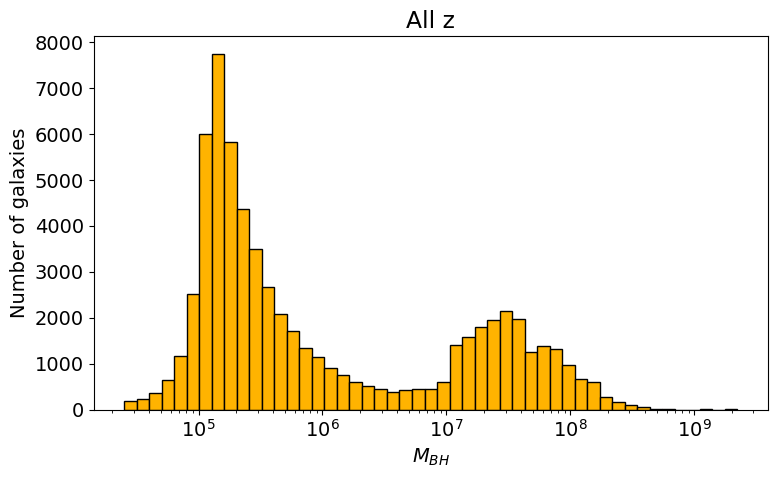

In [60]:
# Ensure arrays are numpy and float64
mbh_filtered = np.asarray(mbh, dtype=np.float64)[mdot > 0]

print(min(mbh_filtered), max(mbh_filtered))

# Histogram with logarithmic x-axis
plt.figure(figsize=(8,5))
plt.hist(mbh_filtered, bins=np.logspace(np.log10(mbh_filtered.min()), 
                                    np.log10(mbh_filtered.max()), 
                                    50),  # 50 log-spaced bins
         edgecolor="black",
         facecolor="#ffb300")
plt.xscale("log")
plt.xlabel(r"$M_{BH}$")
plt.ylabel("Number of galaxies")
plt.title("All z")
plt.tight_layout()
plt.show()

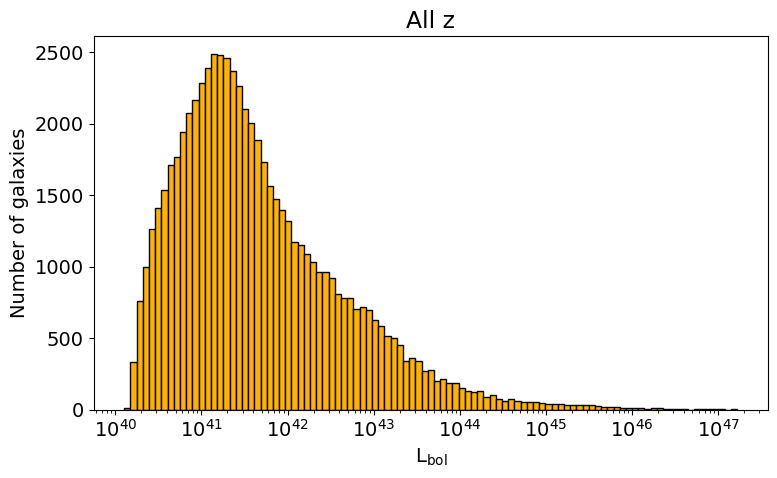

In [61]:
# Histogram with log-scaled x-axis
plt.figure(figsize=(8,5))
plt.hist(L_bol, bins=np.logspace(np.log10(L_bol.min()),
                                           np.log10(L_bol.max()), 100),
         edgecolor="black",
         facecolor="#ffb300")
plt.xscale("log")
plt.xlabel(r"$\rm L_{bol}$")
plt.ylabel("Number of galaxies")
plt.title(f'All z')
plt.tight_layout()
plt.show()

/tmp/ipykernel_161846/707930651.py:1: RuntimeWarning: divide by zero encountered in log10
  ratio = np.log10(mstar) / np.log10(mhalo)


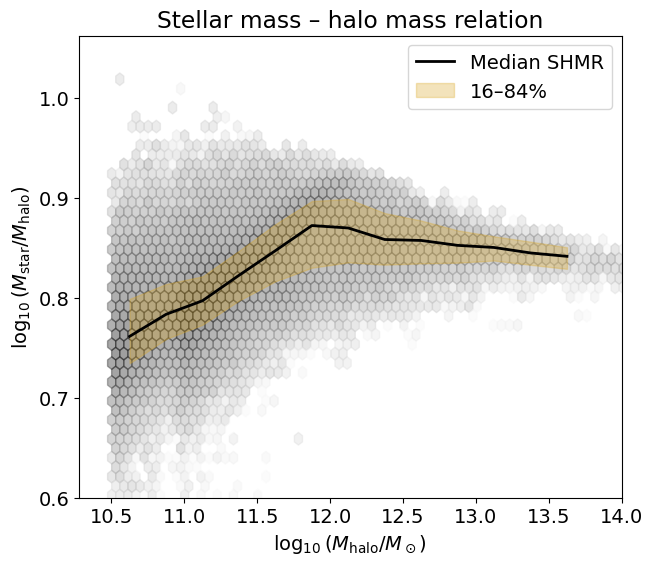

In [62]:
ratio = np.log10(mstar) / np.log10(mhalo)

# Define halo mass bins
bins = np.arange(10, 14, 0.25)   # from 1e10 to 1e15 Msun
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Digitize halo masses into bins
inds = np.digitize(np.log10(mhalo), bins)

medians, p16, p84 = [], [], []

for i in range(1, len(bins)):
    in_bin = ratio[inds == i]
    if len(in_bin) > 10:  # require at least 10 galaxies per bin
        medians.append(np.median(in_bin))
        p16.append(np.percentile(in_bin, 16))
        p84.append(np.percentile(in_bin, 84))
    else:
        medians.append(np.nan)
        p16.append(np.nan)
        p84.append(np.nan)

# Convert to arrays
medians = np.array(medians)
p16 = np.array(p16)
p84 = np.array(p84)

# Plot
plt.figure(figsize=(7,6))

# Scatter for context
plt.hexbin(np.log10(mhalo), ratio, gridsize=80, bins='log', cmap='Greys', mincnt=1, alpha=0.4)

# Median + scatter
plt.plot(bin_centers, medians, color="black", lw=2, label="Median SHMR")
plt.fill_between(bin_centers, p16, p84, color="#daa520", alpha=0.3, label="16–84%")

plt.xlabel(r"$\log_{10}(M_{\rm halo}/M_\odot)$")
plt.ylabel(r"$\log_{10}(M_{\rm star}/M_{\rm halo})$")
plt.title("Stellar mass – halo mass relation")
plt.xlim(right=14)
plt.ylim(bottom=0.6)
plt.legend()
plt.show()

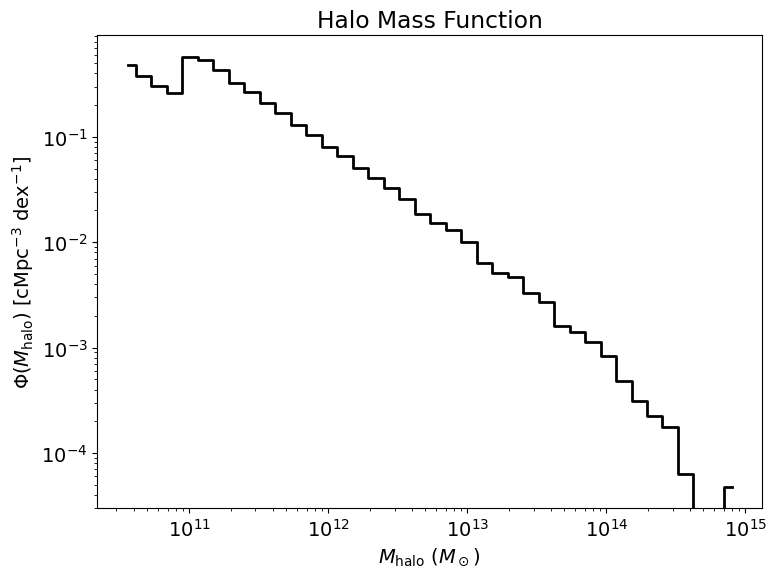

In [63]:
# Plot the halo mass function (HMF)
logMhalo = np.log10(mhalo)
survey_volume = 150**3  # cMpc^3

# Define log mass bins
nbins = 40
logM_bins = np.linspace(logMhalo.min(), logMhalo.max(), nbins + 1)
bin_centers = 0.5 * (logM_bins[:-1] + logM_bins[1:])
bin_width = logM_bins[1] - logM_bins[0]

# Histogram
counts, _ = np.histogram(logMhalo, bins=logM_bins)
phi = counts / (survey_volume * bin_width)  # [cMpc^-3 dex^-1]

plt.figure(figsize=(8,6))
plt.plot(10**bin_centers, phi, drawstyle='steps-mid', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm halo}$ ($M_\odot$)')
plt.ylabel(r'$\Phi(M_{\rm halo})$ [cMpc$^{-3}$ dex$^{-1}$]')
plt.title('Halo Mass Function')
plt.tight_layout()
plt.show()

In [64]:
# Solar luminosity in ergs/s
L_sun = 3.828e33 

def bolometric_corrections(L_bol_array):
    """
    Calculates dispersed luminosities in different quasar bands
    from bolometric luminosities using Shen et al. (2020) corrections.
    
    Parameters
    ----------
    L_bol_array : array-like or float
        Bolometric luminosities in ergs/s.
    
    Returns
    -------
    dict
        Dictionary containing NumPy arrays for each band.
    """
    
    # float64 is needed since float32 wasn’t precise enough for the 
    # scale of the numbers
    L_bol_array = L_bol_array.astype(np.float64)
    
    log_L_bol = np.log10(L_bol_array)
    
    # Bolometric correction parameters
    params = {
        'B':  {'c1':3.759, 'k1':-0.361, 'c2':9.830, 'k2':-0.0063, 'sigma1':-0.383, 'sigma2':0.405, 'log_L0':42.39, 'sigma3':2.378},
        'UV': {'c1':1.862, 'k1':-0.361, 'c2':4.870, 'k2':-0.0063, 'sigma1':-0.372, 'sigma2':0.405, 'log_L0':42.31, 'sigma3':2.310},
        'Xsoft': {'c1':5.712, 'k1':-0.026, 'c2':17.67, 'k2':0.278, 'sigma1':0.080, 'sigma2':0.180, 'log_L0':44.16, 'sigma3':1.496},
        'Xhard': {'c1':4.073, 'k1':-0.026, 'c2':12.60, 'k2':0.278, 'sigma1':0.193, 'sigma2':0.066, 'log_L0':42.99, 'sigma3':1.883},
        'IR': {'c1':4.361, 'k1':-0.361, 'c2':11.40, 'k2':-0.0063, 'sigma1':-0.338, 'sigma2':0.407, 'log_L0':42.16, 'sigma3':2.193}
    }
    
    result = {}
    
    for band, p in params.items():
        # Mean luminosity
        denom = p['c1'] * (L_bol_array / (L_sun * 1e10))**p['k1'] + p['c2'] * (L_bol_array / (L_sun * 1e10))**p['k2']
        L_mean = L_bol_array / denom
        
        # Scatter
        scatter = ((p['sigma1'] + p['sigma2']) / 2 +
                   (p['sigma1'] - p['sigma2']) / 2 * erf((log_L_bol - p['log_L0']) / (np.sqrt(2) * p['sigma3'])))
        scatter = np.abs(scatter)  # ensure non-negative
        
        # Apply log-normal scatter
        L_disp = 10 ** np.random.normal(np.log10(L_mean), scatter)
        result[band] = L_mean # try to see if results are better without scatter
    
    return result

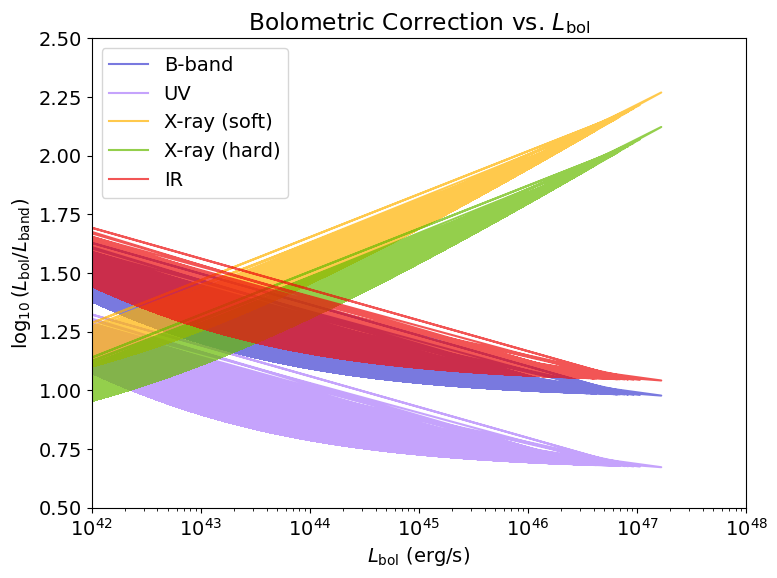

In [65]:
# Recreate Fig 2 of Shen et al. (2020) 

luminosities = bolometric_corrections(L_bol)

plt.figure(figsize=(8,6))

band_labels = {
    "B": "B-band",
    "UV": "UV",
    "Xsoft": "X-ray (soft)",
    "Xhard": "X-ray (hard)",
    "IR": "IR"
}

colors = {
    "B": "#4141D2",
    "UV": "#ad7cfb",
    "Xsoft": "#ffb300",
    "Xhard": "#67bb00",
    "IR": "#ED0D0D"
}

for band in luminosities:
    L_band = luminosities[band]
    plt.plot(
        L_bol,
        np.log10(L_bol / L_band),
        '-', 
        label=band_labels[band], 
        color=colors[band], 
        alpha=0.7, 
        markersize=4
    )

plt.xscale('log')
plt.xlabel(r'$L_{\rm bol}$ (erg/s)')
plt.ylabel(r'$\log_{10}(L_{\rm bol}/L_{\rm band})$')
plt.ylim(bottom=0.5, top=2.5)
plt.xlim(left=1e42, right=1e48)
plt.legend()
plt.title('Bolometric Correction vs. $L_{\\rm bol}$')
plt.tight_layout()
plt.show()

To check that these bolometric corrections have been done correctly, I compared to Fig 2 of Shen+20 and it agrees well.

<img src="./corrections.png" width="500"/>

In [66]:
def luminosity_function(band_luminosities, survey_volume, nbins=12, logL_range=None):
    """Compute luminosity function Phi(L) in Mpc^-3 dex^-1."""
    
    L = np.asarray(band_luminosities)

    # Default logL range
    if logL_range is None:
        logL_min = np.log10(L.min()) - 0.1
        logL_max = np.log10(L.max()) + 0.1
        logL_range = (logL_min, logL_max)

    logL_bins = np.linspace(logL_range[0], logL_range[1], nbins + 1)
    bin_centers = 0.5 * (logL_bins[:-1] + logL_bins[1:])

    counts, _ = np.histogram(np.log10(L), bins=logL_bins)
    counts = np.nan_to_num(counts, nan=0.0, posinf=0.0, neginf=0.0)

    bin_width = np.diff(logL_bins)[0]
    phi = counts / (survey_volume * bin_width)
    phi_err = np.sqrt(counts) / (survey_volume * bin_width)

    # Mask empty bins
    phi = np.where(counts > 0, phi, np.nan)
    phi_err = np.where(counts > 0, phi_err, np.nan)

    return bin_centers, phi, phi_err, counts


Text(0, 0.5, '$\\Phi(L_{\\rm bol})$ [cMpc$^{-3}$ dex$^{-1}$]')

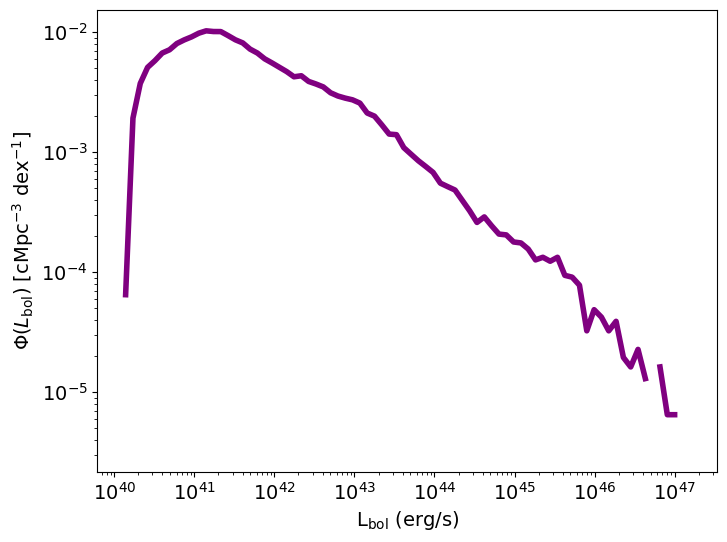

In [67]:
# Compute bolometric luminosity function
logL_centers, phi, phi_err, counts = luminosity_function(L_bol, 150**3, nbins=80)

plt.figure(figsize=(8,6))
plt.plot(10**logL_centers, phi, color='purple', lw=4, ls='-')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"L$_{\rm bol}$ (erg/s)")
plt.ylabel(r"$\Phi(L_{\rm bol})$ [cMpc$^{-3}$ dex$^{-1}$]")

In [68]:
band_map = {
    "B-band": "B",
    "UV": "UV",
    "X-ray (soft)": "Xsoft",
    "X-ray (hard)": "Xhard",
    "IR": "IR",
}

band_colors = {
    "B-band": "#4141D2",
    "UV": "#ad7cfb",
    "X-ray (soft)": "#ffb300",
    "X-ray (hard)": "#67bb00",
    "IR": "#ED0D0D"
}

def plot_band_lf_vs_redshift(
    band_key,
    L_bol, z, 
    survey_volume,
    z_bins,
    nbins=20,
    band_label=None,
    band_color=None
):
    """
    Plot the luminosity function for a single band in multiple redshift bins.

    Parameters
    ----------
    band_key : str
        Key for the band in bolometric_corrections (e.g. "B", "UV", "Xsoft", "Xhard", "IR").
    L_bol : array
        Bolometric luminosities (erg/s).
    z : array
        Redshifts.
    survey_volume : float
        Volume in cMpc^3.
    z_bins : array-like
        Redshift bin edges.
    nbins : int
        Number of luminosity bins.
    band_label : str or None
        Label for the band (for plot).
    band_color : str or None
        Color for the band (for plot).
    """

    # Find label and color from band_key
    label_lookup = {v: k for k, v in band_map.items()}
    band_label = label_lookup.get(band_key, band_key)
    band_color = band_colors.get(band_label, "#4141D2")

    fig, axes = plt.subplots(1, len(z_bins)-1, figsize=(5*(len(z_bins)-1), 5), sharey=True)
    if len(z_bins)-1 == 1:
        axes = [axes]

    for i in range(len(z_bins)-1):
        zmin, zmax = z_bins[i], z_bins[i+1]
        mask = (z >= zmin) & (z < zmax)
        if np.sum(mask) == 0:
            continue
        L_bol_bin = L_bol[mask]
        # Get band luminosities
        band_lum = bolometric_corrections(L_bol_bin)[band_key]
        # Remove non-positive values
        band_lum = band_lum[band_lum > 0]
        # Compute LF
        logL_centers, phi, phi_err, counts = luminosity_function(band_lum, survey_volume, nbins=nbins)
        ax = axes[i]
        ax.plot(10**logL_centers, phi, color=band_color, lw=4)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("L (erg/s)")
        if i == 0:
            ax.set_ylabel(r"$\Phi(L)$ [cMpc$^{-3}$ dex$^{-1}$]")
        ax.set_title(f"z={zmin:.2f}-{zmax:.2f}")
        ax.set_ylim(bottom=1e-6)
    fig.suptitle(f"{band_label}", fontsize=18)
    plt.tight_layout()

    return fig, axes

[-5.95216734e+30 -5.93005849e+30 -5.90812563e+30 -5.88636660e+30
 -5.86477930e+30 -5.84336166e+30 -5.82211164e+30 -5.80102723e+30
 -5.78010647e+30 -5.75934740e+30 -5.73874812e+30 -5.71830675e+30
 -5.69802144e+30 -5.67789036e+30 -5.65791172e+30 -5.63808376e+30
 -5.61840473e+30 -5.59887294e+30 -5.57948669e+30 -5.56024432e+30
 -5.54114420e+30 -5.52218473e+30 -5.50336432e+30 -5.48468141e+30
 -5.46613446e+30 -5.44772196e+30 -5.42944242e+30 -5.41129437e+30
 -5.39327637e+30 -5.37538699e+30 -5.35762482e+30 -5.33998848e+30
 -5.32247662e+30 -5.30508787e+30 -5.28782093e+30 -5.27067448e+30
 -5.25364724e+30 -5.23673794e+30 -5.21994534e+30 -5.20326819e+30
 -5.18670529e+30 -5.17025544e+30 -5.15391745e+30 -5.13769017e+30
 -5.12157245e+30 -5.10556315e+30 -5.08966116e+30 -5.07386538e+30
 -5.05817472e+30 -5.04258812e+30]


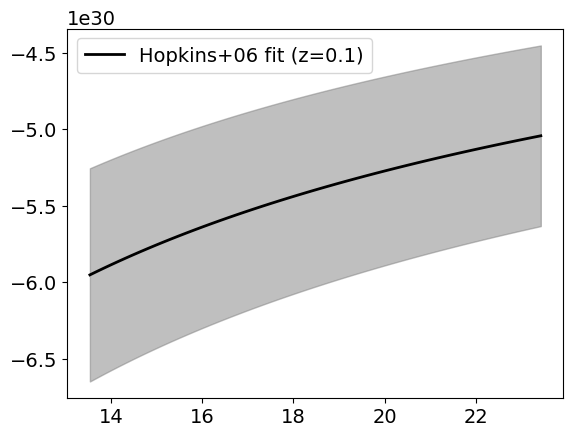

In [69]:
Lsun = 3.828e33  # Solar luminosity in erg/s

def lf_fit(L, phi_0, L_0, gamma_1, gamma_2):

    phi = phi_0 / ((L/L_0)**gamma_1 + (L/L_0)**gamma_2) 

    return phi 

# Fit values from Hopkins+06 for z = 0.1
phi_0 = (-5.45, 0.28)
L_0 = (11.94 * L_sun, 0.21 * L_sun) # units of log(Lsun) 
gamma_1 = (0.868, 0.050)
gamma_2 = (1.97, 0.17)

L_fit = np.linspace(38, 46, 50) / np.log10(Lsun)

phi_fit = lf_fit(L_fit, phi_0[0], L_0[0], gamma_1[0], gamma_2[0])   

phi_fit_err = phi_fit * np.sqrt(
    (phi_0[1]/phi_0[0])**2 +
    (L_0[1]/L_0[0])**2 +
    (gamma_1[1]/gamma_1[0])**2 +
    (gamma_2[1]/gamma_2[0])**2
)

print(phi_fit)

plt.fill_between(10**L_fit, phi_fit - phi_fit_err, phi_fit + phi_fit_err, color='gray', alpha=0.5)
plt.plot(10**L_fit, phi_fit, color='black', lw=2, label='Hopkins+06 fit (z=0.1)')
plt.legend()

plt.show()

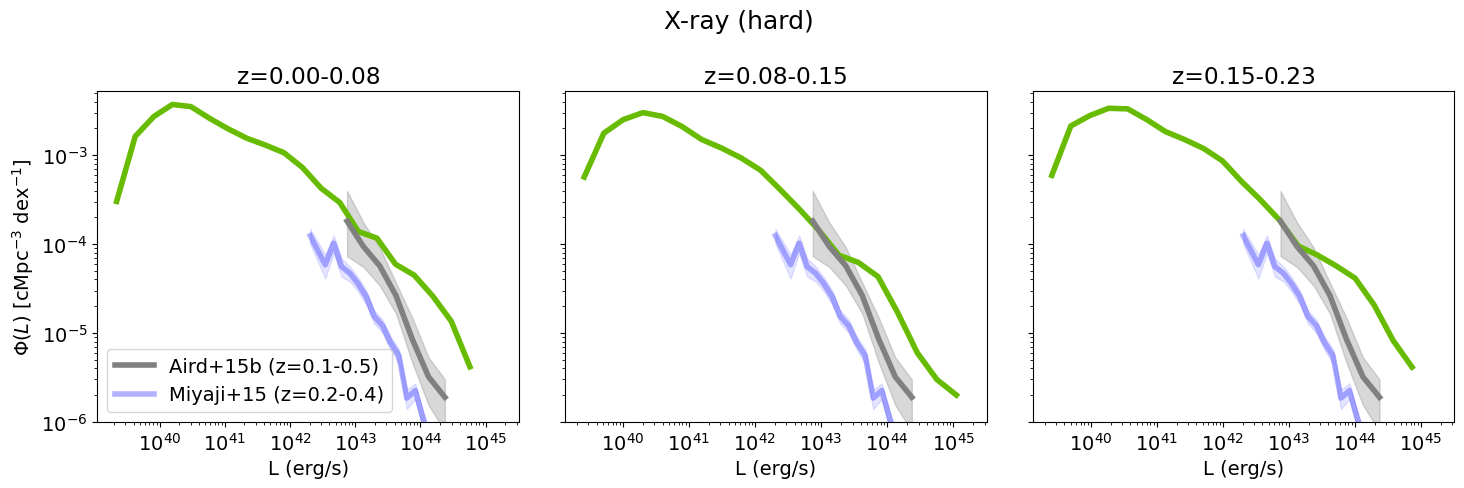

In [70]:
# Divide z bins automatically
n_bins = 3
z_bins = np.linspace(min(z), max(z), n_bins+1)

fig, axes = plot_band_lf_vs_redshift(
    band_key="Xhard",
    L_bol=L_bol,
    z=z,
    survey_volume=150**3,
    z_bins=z_bins,
    nbins=20
)

# Aird et al. (2015b) data
# z = 0.1 - 0.5, with mean z of 0.28

# log L10–40 keV bin edges
aird_logL_bins = [
    (42.75, 43.00),
    (43.00, 43.25),
    (43.25, 43.50),
    (43.50, 43.75),
    (43.75, 44.00),
    (44.00, 44.25),
    (44.25, 44.50)
]

# Compute midpoints
aird_logL_midpoints = 10 ** np.array([(low + high) / 2 for low, high in aird_logL_bins])

# φ_noabs values
aird_phi_noabs = np.array([1.81e-4, 9.39e-5, 5.69e-5, 2.63e-5, 8.48e-6, 3.20e-6, 1.89e-6])
aird_phi_noabs_err_up = np.array([2.14e-4, 8.13e-5, 3.50e-5, 1.03e-5, 6.33e-6, 2.09e-6, 1.11e-6])
aird_phi_noabs_err_low = np.array([1.08e-4, 3.87e-5, 2.27e-5, 9.8e-6, 3.85e-6, 1.66e-6, 1.11e-6])

# Compute upper/lower bounds
def make_bounds(phi, err_up, err_low):
    return phi + err_up, phi - err_low

aird_phi_noabs_up, aird_phi_noabs_low = make_bounds(aird_phi_noabs, aird_phi_noabs_err_up, aird_phi_noabs_err_low)

# Miyaji+15 data

miyaji_log_L_bins = 10 ** np.array([42.31, 42.54, 42.67, 42.79, 42.92, 43.04, 43.17, 43.29, 43.42, 43.54, 43.67, 43.79, 43.92, 44.04, 44.17, 44.32, 44.49, 44.63, 44.90, 45.22])

miyaji_phi = np.array([1.24e-4, 5.85e-5, 1.02e-4, 5.58e-5, 4.68e-5, 3.61e-5, 2.54e-5, 1.54e-5, 1.20e-5, 7.81e-6, 5.55e-6, 1.85e-6, 2.25e-6, 1.08e-6, 5.18e-7, 1.44e-7, 1.34e-7, 7.88e-8, 7.51e-9, 2.53e-9])
miyaji_phi_err = np.array([0.24e-4, 1.76e-5, 0.23e-4, 1.28e-5, 0.89e-5, 0.65e-5, 0.46e-5, 0.26e-5, 0.20e-5, 1.33e-6, 1.00e-6, 0.46e-6, 0.45e-6, 0.25e-6, 1.45e-7, 0.48e-7, 0.43e-7, 2.36e-8, 2.85e-9, 1.77e-9])

miyaji_phi_up, miyaji_phi_low = make_bounds(miyaji_phi, miyaji_phi_err, miyaji_phi_err)



for ax in axes:

    # Plot Aird+15b data
    ax.plot(aird_logL_midpoints, aird_phi_noabs, color='gray', lw=4, label='Aird+15b (z=0.1-0.5)')
    ax.fill_between(aird_logL_midpoints, aird_phi_noabs_low, aird_phi_noabs_up, color='gray', alpha=0.3)

    # Plot Miyaji+15 data
    ax.plot(miyaji_log_L_bins, miyaji_phi, color='blue', label='Miyaji+15 (z=0.2-0.4)', alpha=0.3, lw=4)
    ax.fill_between(miyaji_log_L_bins, miyaji_phi_low, miyaji_phi_up, color='blue', alpha=0.1)


axes[0].legend()

plt.show()

In [71]:
# sanity checks — run in the same kernel
bc = bolometric_corrections(L_bol)

# Are the band arrays identical?
print("allclose UV vs IR:", np.allclose(bc['UV'], bc['IR']))
print("UV min/max:", np.min(bc['UV']), np.max(bc['UV']))
print("IR min/max:", np.min(bc['IR']), np.max(bc['IR']))

# Show first few values
print("UV[:5]:", bc['UV'][:5])
print("IR[:5]:", bc['IR'][:5])


allclose UV vs IR: False
UV min/max: 3.290934156259271e+38 3.525429344283228e+46
IR min/max: 1.4052167274685428e+38 1.5060233034680293e+46
UV[:5]: [3.03327042e+42 9.83307327e+41 4.58061853e+41 3.06299429e+41
 2.26125624e+41]
IR[:5]: [1.29557280e+42 4.19972956e+41 1.95633392e+41 1.30815156e+41
 9.65731533e+40]


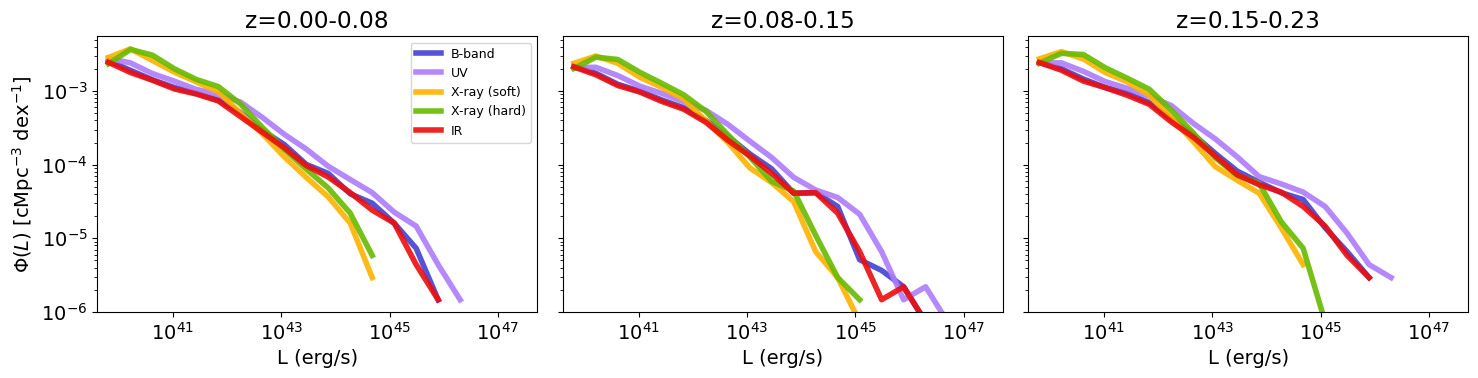

In [72]:
plt.close('all')

def plot_all_bands_lf_three_zbins(L_bol, z, z_bins, survey_volume=150**3, nbins=20,
                                  bands=['B','UV','Xsoft','Xhard','IR']):
    colors = {'B':'#4141D2','UV':'#ad7cfb','Xsoft':'#ffb300','Xhard':'#67bb00','IR':'#ED0D0D'}
    labels = {'B':'B-band','UV':'UV','Xsoft':'X-ray (soft)','Xhard':'X-ray (hard)','IR':'IR'}

    # common logL range for all panels (use bolometric L range mapped to band L later)
    logL_min = np.log10(L_bol.min()) - 0.5
    logL_max = np.log10(L_bol.max()) + 0.5
    logL_range = (logL_min, logL_max)

    n_panels = len(z_bins) - 1
    fig, axes = plt.subplots(1, n_panels, figsize=(5*n_panels,4), sharey=True)
    if n_panels == 1:
        axes = [axes]

    for i in range(n_panels):
        ax = axes[i]
        zmin, zmax = z_bins[i], z_bins[i+1]
        mask = (z >= zmin) & (z < zmax)
        if np.sum(mask) == 0:
            ax.set_title(f"z={zmin:.2f}-{zmax:.2f} (no data)")
            continue

        L_bol_bin = L_bol[mask]
        # get band luminosities once for this bin
        bc_bin = bolometric_corrections(L_bol_bin)

        for band in bands:
            band_lum = bc_bin[band]
            band_lum = band_lum[band_lum > 0]
            if band_lum.size == 0:
                continue
            logL_centers, phi, phi_err, counts = luminosity_function(band_lum, survey_volume,
                                                                      nbins=nbins, logL_range=logL_range)
            ax.plot(10**logL_centers, phi, ls='-', color=colors[band],
                        label=labels.get(band, band), alpha=0.9, lw=4)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('L (erg/s)')
        ax.set_title(f"z={zmin:.2f}-{zmax:.2f}")
        ax.set_xlim(10**logL_range[0], 10**logL_range[1])
        ax.set_ylim(bottom=1e-6)
        if i == 0:
            ax.set_ylabel(r"$\Phi(L)$ [cMpc$^{-3}$ dex$^{-1}$]")
            ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    return fig, axes

# usage: ensure z_bins has three bins (len=4)
fig, axes = plot_all_bands_lf_three_zbins(L_bol=L_bol, z=z, z_bins=z_bins, survey_volume=150**3, nbins=20)
plt.show()